## Text classification with deep learning

In [52]:
# system tools
import os
import sys
sys.path.append(os.path.join(".."))

# pandas, numpy, gensim
import pandas as pd
import numpy as np
import gensim.downloader

# import my classifier utility functions - see the Github repo!
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ShuffleSplit # cross-validation
from sklearn import metrics

# tools from tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Embedding, 
                                     Flatten, GlobalMaxPool1D, Conv1D)
from tensorflow.keras.optimizers import SGD, Adam # optimization algorithms
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import L2 # regularization

# matplotlib
import matplotlib.pyplot as plt

# Creating a dictionary 
# Binary classification: 0 = negative, 1 = positive
filepath_dict = {'yelp':   '../data/cnns/yelp_labelled.txt',
                 'amazon': '../data/cnns/amazon_cells_labelled.txt',
                 'imdb':   '../data/cnns/imdb_labelled.txt'}

We want to classify whether a document is positive (1) or negative (0)

__Helper functions for later__

In [53]:
def plot_history(H, epochs):
    """
    Utility function for plotting model history using matplotlib
    
    H: model history 
    epochs: number of epochs for which the model was trained
    """
    plt.style.use("fivethirtyeight")
    plt.figure()
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

def create_embedding_matrix(filepath, word_index, embedding_dim):
    """ 
    A helper function to read in saved GloVe embeddings and create an embedding matrix
    
    filepath: path to GloVe embedding
    word_index: indices from keras Tokenizer
    embedding_dim: dimensions of keras embedding layer
    """
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## Load all data into single dataframe

We want all the data in a single dataframe. This is maybe not the best practice, especially with larger datasets, because it is not good to load everything into memory. But it does allow us to quickly iterate over different datasets!

In [54]:
df_list = []

# for each filepath in the filepath_dict
for source, filepath in filepath_dict.items():
    # read csv
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t') # \t means tab-separated
    # Add another column filled with the source name
    df['source'] = source 
    df_list.append(df)

# concatenate into a single dataframe
# The df_list contains 3 dataframes. Hence, each entry is a dataframe
df = pd.concat(df_list) # compressing the 3 dataframes into a single dataframe
# inspect first entry
print(df.iloc[0])
# Each entry we have the sentence, label, and source

sentence    Wow... Loved this place.
label                              1
source                          yelp
Name: 0, dtype: object


In [55]:
df
# Now we have just one long dataframe instead of 3 separate

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
743,I just got bored watching Jessice Lange take h...,0,imdb
744,"Unfortunately, any virtue in this film's produ...",0,imdb
745,"In a word, it is embarrassing.",0,imdb
746,Exceptionally bad!,0,imdb


## Select only yelp reviews (or other subset)

In [56]:
# Taking every entry with yelp as the source
df_yelp = df[df['source'] == 'yelp']

# get the values in each cell; returns a list
sentences = df_yelp['sentence'].values # taking sentences
labels = df_yelp['label'].values # taking labels

# train and test split using sklearn
X_train, X_test, y_train, y_test = train_test_split(sentences, 
                                                    labels, 
                                                    test_size=0.25, 
                                                    random_state=42)

## Vectorize using ```sklearn```

We need to create a benchmark to use for comparison. This benchmark is a logistic regression classifier. 

This is exactly what we have done a whole bunch previously - vecorizing using ```sklearn```.

Here, we're not going to make any special modifications, we're just using default parameters.

In [57]:
# Initializing a count vectorizer with default parameters
vectorizer = CountVectorizer()

We then 'fit' our vectorizer and our data

In [92]:
# First we do it for our training data...
X_train_feats = vectorizer.fit_transform(X_train)
#... then we do it for our test data
X_test_feats = vectorizer.transform(X_test)

## Logistic regression classifier

Nothing fancy, just a simple baseline.

In [59]:
# Fitting the classifier
classifier = LogisticRegression(random_state=42).fit(X_train_feats, y_train)

In [60]:
# Get predictions
y_pred = classifier.predict(X_test_feats)

## Evaluate

In [61]:
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

           0       0.81      0.84      0.82       128
           1       0.82      0.80      0.81       122

    accuracy                           0.82       250
   macro avg       0.82      0.82      0.82       250
weighted avg       0.82      0.82      0.82       250



An F1-score of 0.82 is pretty good. 

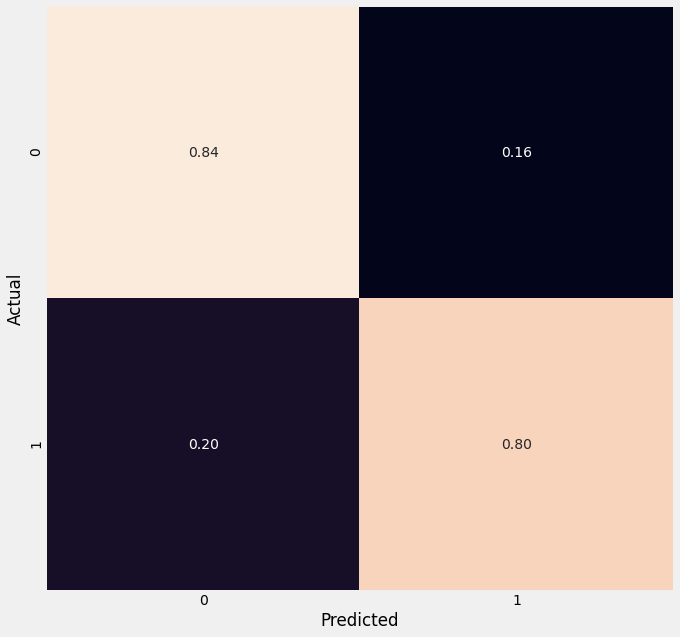

In [93]:
# Plotting TP, TN, FP, FN
clf.plot_cm(y_test, y_pred, normalized=True)

## Cross validation

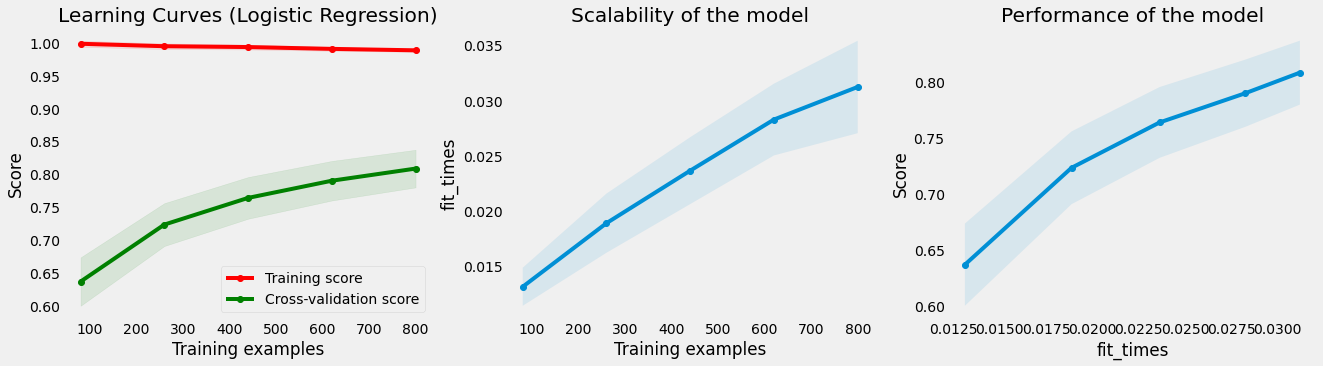

In [63]:
# Vectorize full dataset
X_vect = vectorizer.fit_transform(sentences)

# initialise cross-validation method
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# run on data
model = LogisticRegression(random_state=42)
clf.plot_learning_curve(model, title, X_vect, labels, cv=cv, n_jobs=4)

__Q:__ What do you think of this model? Does it perform well?

We can see that the cross-validation score is increasing over time, while the training score remains pretty stable over time suggesting overfitting. Generally speaking the model is performing reasonably well, but we want less of a gap between the cross-validation curve and the training score curve. We would also want the training score to be more below 100%, in order to not be overfitting as much. 
We can also see that the model scales linearly. We can also see that when adding more data, we get better accuracy. 
The middle plot tells us the time it takes to fit the model based on how much data we have - hence, the more data we have the more time it takes to train it. 

__Conclusion:__ it is an OK model, but we need to address the overfitting

## Test on all data sources

Let's quickly iterate over each source of data, to see how well this model performs on different datasets.

In [64]:
# For each source get the accuracy
for source in df['source'].unique():
    df_source = df[df['source'] == source]
    sentences = df_source['sentence'].values
    y = df_source['label'].values

    X_train1, X_test1, y_train1, y_test1 = train_test_split(
        sentences, y, test_size=0.25, random_state=1000)

    # vectorize
    vectorizer = CountVectorizer()
    # First we do it for our training data...
    X_train_feats1 = vectorizer.fit_transform(X_train1)
    #... then we do it for our test data
    X_test_feats1 = vectorizer.transform(X_test1)

    classifier = LogisticRegression(random_state=42).fit(X_train_feats1, y_train1)
    score = classifier.score(X_test_feats1, y_test1)
    print('Accuracy for {} data: {:.4f}'.format(source, score))

Accuracy for yelp data: 0.7960
Accuracy for amazon data: 0.7960
Accuracy for imdb data: 0.7487


We can see that using logistic regression, we can get pretty good accuracies on all datasets. This corresponds to the cross-validation scores from before. 
Hence, this is our benchmark - around 80% seems to be the maximum performance of the logistic regression classifier. Let's see if we can train a deep learning model that performs better. 

## Using deep learning

Let's see if we can train a deep learning model that performs better than the logistic regression classifier

In [65]:
# Clearing sessions (deleting already trained models)
tf.keras.backend.clear_session()

__Simple fully-connected network__

In [66]:
# define architecture
input_shape = X_train_feats.shape[0:]

# define architecture Input -> 10 -> 1
# 10 = hidden layer
# 1 = output layer (we are only working with 1 because we are working with a binary classification)
model = Sequential()
model.add(Dense(10, 
                input_shape=input_shape, 
                activation="relu")) # each of the 10 nodes has a relu activation function
model.add(Dense(1, activation="sigmoid")) # we are using sigmoid because we are working with a binary classification

Softmax is a generalization of logistic regression to work with multiple classes. With the softmax functio we are getting a probability for each class. Hence, when we are working with a categorical classification problem with many classes we would use softmax as the output layer, while when we are working with a binary classification problem, we work with the sigmoid function. 

__Compile model__

In [67]:
model.compile(loss='binary_crossentropy', # binary classification
              optimizer="adam", # adam is an optimization algorithm that is extremely effective and fast
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 750, 10)           17290     
_________________________________________________________________
dense_1 (Dense)              (None, 750, 1)            11        
Total params: 17,301
Trainable params: 17,301
Non-trainable params: 0
_________________________________________________________________


Output layer = 1 node <br>
Hidden layer = 10 nodes

Notice that we're using a different optimization algorithm. We've been primarily working with Stochastic Gradient Descent; here we're working with ADAM - you can learn more [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

```tf.keras()``` has a range of optimization algorithms, with slighly different uses. Read more [here](https://keras.io/api/optimizers/).

__Q:__ Rather than calculate loss as categorical_crossentropy, we're using binary_crossentropy. Why might that be?

In [68]:
#plot_model(model, show_shapes=True, show_layer_names=True)

__Train model and evaluate__

In [69]:
history = model.fit(X_train_feats, y_train, 
                    validation_data=(X_test_feats, y_test), 
                    verbose=False, # mute the output, so it doesn't print loads to screen
                    epochs=50,
                    batch_size=10)

Evaluate the model performance using keras:

In [70]:
loss, accuracy = model.evaluate(X_train_feats, 
                                y_train, 
                                verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))

loss, accuracy = model.evaluate(X_test_feats, 
                                y_test, 
                                verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.8120


We can see that on the training data we have an accuracy of 1 (100%), while on the testing data we have an accuracy of 80%. 

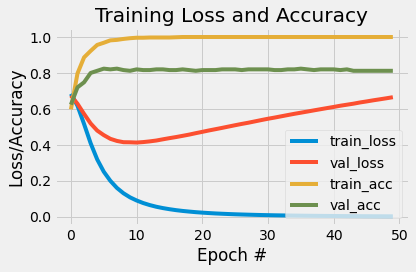

In [71]:
plot_history(history, epochs=50)

There is a problem with overfitting- the training and validation data hit a platey very quickly (after 5 epochs). The validation loss diverges very quickly, which means that it is not minimizing the loss on the validation data, suggesting that there is overfitting. 
Hence, the model is good on the training data, but it does not generalize well to new data. 

Why is the val_loss not directly opposite of the the val_acc?
- The val_acc very slightly decreases over time - hence, they are mirroing each other, but not directly 1:1

## Word embeddings

__Using ```tf.keras.Tokenizer()```__

Using ```tensorflow.keras.Tokenizer()``` allows us to quickly and efficiently convert text to numbers.

tensorflow has some good tools for working with text data. 

In [72]:
# initialize tokenizer
tokenizer = Tokenizer(num_words=5000) # vocabulary = 5000 words
# fit to raw training data
tokenizer.fit_on_texts(X_train)

# tokenized training and test data
# Hence, we use the tokenizer to create sequences of tokens
X_train_toks = tokenizer.texts_to_sequences(X_train)
X_test_toks = tokenizer.texts_to_sequences(X_test)

# overall vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

# inspect
print(X_train[2]) # text number 2
print(X_train_toks[2]) 

Great atmosphere, friendly and fast service.
[18, 139, 59, 2, 289, 20]


The tokenizer has split the words and assigned each word a numerical reference, e.g. "great" = 18. 

__However!__


Notice how the ```tf.keras``` tokenizer output is different to ```CountVectorizer()```. Why not? How is it different?
- The difference is that with keras we are not counting how often the word appears, but rather the number for each word is just an assigned index. Hence, the vector for a sentence is not a count representation, btu rather an index numerical represenation - this is more similar to one-hot encoding rahter than a count vector. Hence, with keras we are not modeling the count distribution of the text. 

__Padding__

We need to make the documents the same length. We can do this with *padding*

To make the Tokenizer output workable, we need to *pad* the documents to be of equal length. 

Compare this to how we pad images when using CNNs on image data.

In [73]:
# max length for a doc
maxlen = 100 # 100 as the max length is arbitrary

# pad training data to maxlen
X_train_pad = pad_sequences(X_train_toks, 
                            padding='post', # post = puts the pads at end of the sequence. Sequences can be padded "pre" or "post"
                            maxlen=maxlen)
# pad testing data to maxlen
X_test_pad = pad_sequences(X_test_toks, 
                           padding='post', 
                           maxlen=maxlen)

In [74]:
# inspect
print(X_train[2])
print(X_train_toks[2])
print(X_train_pad[2])

Great atmosphere, friendly and fast service.
[18, 139, 59, 2, 289, 20]
[ 18 139  59   2 289  20   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


^Now we have padded the documents with a lot of 0s at the end. Hence, now the document is represented as a vector of 100 points, which means that every document is represented with a vector of the same size. This is a very sparse representation that does not contain any information. 

__Keras embedding layer__

We now need to convert this numerical representation of the text into a dense, embedded representation.

This can be done quite simply using ```tensorflow.keras```

keras takes the numerical inputs and learns embedded representations of the words for each document in order to get rid of the sparsity, and instead have a dense representation. 

In [75]:
# define embedding size we want to work with
embedding_dim = 50

# initialize Sequential model
model = Sequential()
# add Embedding layer
model.add(Embedding(input_dim=vocab_size,     # vocab size from Tokenizer()
                    output_dim=embedding_dim, # user defined embedding size
                    input_length=maxlen))     # maxlen of padded docs
# add Flatten layer
model.add(Flatten())
# Add Dense layer; 10 neurons; ReLU activation
model.add(Dense(10, 
                activation='relu'))
# Add prediction node; 1 node with sigmoid; approximates Logistic Regression
model.add(Dense(1, 
                activation='sigmoid'))

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87850     
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                50010     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 137,871
Trainable params: 137,871
Non-trainable params: 0
_________________________________________________________________


In comparison to the logistic regression classifier model we now have many more trainable parameters.

Input shape = 100
Dimensions = 50

__Train and evaluate__

In [76]:
# Training data
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

In [77]:
# Evaluate model
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.7080


We have a training accuracy of 100% and a testing accuracy of 70% which means that this CNN model performs slightly worse than the logistic regression classifier. 

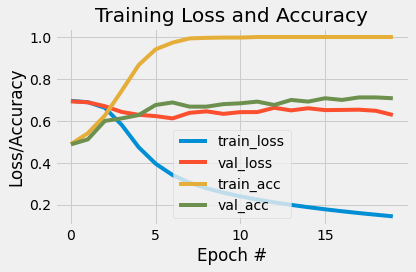

In [78]:
plot_history(history, epochs=20)

We still have a problem of overfitting - the model is performing well on training data, but not well on new, unseen data - hence, it is not generalizing very well. The model starts to diverge very quickly (i.e. it overfits very quickly).  

__Add MaxPooling layer__

We can decrease the amount of noise and increase the signal in the data by using a MaxPool layer immediately after the Embedding layer.

In [79]:
embedding_dim = 50

# Same as before
model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    input_length=maxlen))

# MaxPool replaces Flatten layer
model.add(GlobalMaxPool1D()) # taking the largest value 

# Same as before
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 50)           87850     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 88,371
Trainable params: 88,371
Non-trainable params: 0
_________________________________________________________________


We have gone from 100 documents with 50 dimensions to 50 because of the global maximum pooling function.

__Train and evaluate__

Training Accuracy: 1.0000
Testing Accuracy:  0.8040


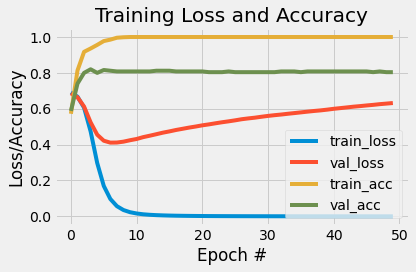

In [80]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# Evaluate
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs=50)

The model is not performing any better than before. Hence, the max pooling has not changed much. 

## Use pretrained ```GloVe``` embedding

Now we are going to see whether we can improve the model by using pretrained word embeddings rather than having keras learn embeddings from the data we have.

__Benefits of using pretrained embeddings__ <br>
Pretrained embeddings have been trained on very large corpora, which measn that they can create more general models. Of course they are still dependent on the data they have been trained on.
Taking advantage of existing "knowledge" - pretrained embeddings encode semantic information from a large pretrained corpus. 

__Download pretrained embedding__

Jupyter allows you to execute command line functions by using ```!```, to save you time.

In [81]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

Now we have word embeddings with different dimensions. Hence, we have a big matrix of words vectors that have been pretrained using GloVe on the stanford dataset(https://nlp.stanford.edu/projects/glove/)

__Create embedding matrix__

We map the vocabulary in our data onto the pretrained embeddings, creating an embedding matrix with one row per word in our vocabulary.

In [82]:
embedding_matrix = create_embedding_matrix('../glove/glove.6B.50d.txt',
                                           tokenizer.word_index, # keeping only the words that appear in our data
                                           embedding_dim)

Now we can add this embedding matrix to the embedding layer in the model. Hence, we use the pretrained word embeddings as weights for each word, which means that we are adding an additional layer of complexity - rather than learning the embeddings from the data, we use the pretrained word embeddings. Hence, keras will learn the embeddings based on the pretrained word embeddings. 

__Train model__

In [83]:
# new model
model = Sequential()
# Embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix],  # we've added our pretrained GloVe weights
                    input_length=maxlen, 
                    trainable=False))            # embeddings are static - not trainable. This means that we are not using the word embeddings as trainable parameters, because this is very time-consuming.

# GlobalMaxPool -> FC -> Output
model.add(GlobalMaxPool1D()) # taking the global maximum value
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# print summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           87850     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 88,371
Trainable params: 521
Non-trainable params: 87,850
_________________________________________________________________


Even though the mebedding layer has around 87.000 parameters, there are onlu 521 trainable parameters in the model. 

Training Accuracy: 0.7640
Testing Accuracy:  0.6840


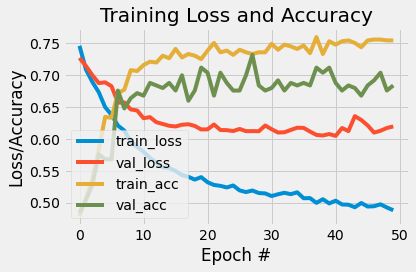

In [84]:
# Train model for 50 epochs
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)

Now we have much lower training accuracy than before (75%). The training loss is decreasing for each epoch. The validation loss is not decreasing that quick, which is not good. 

Hence, there is more noise and variation when using pretrained word embeddings, but we are no longer overfitting the training data which is good. The model performs worse than with logistic regression, BUT we are not overfitting the data. 

## Trainable embedding

Now let's try to use the pretrained word embeddings as trainable parameters. 

In [85]:
# new model
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    weights=[embedding_matrix], # pretrained GloVe weights
                    input_length=maxlen, 
                    trainable=True))            # now we want to train the embeddings, too

# GlobalMaxPool -> FC -> Out
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           87850     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 88,371
Trainable params: 88,371
Non-trainable params: 0
_________________________________________________________________


Now, we have 88.000 trainable parameters - much more than before, because we are using the word embeddings as trainable parameters themselves. This means that the model will learn the word embeddings themselves.  

Training Accuracy: 1.0000
Testing Accuracy:  0.7760


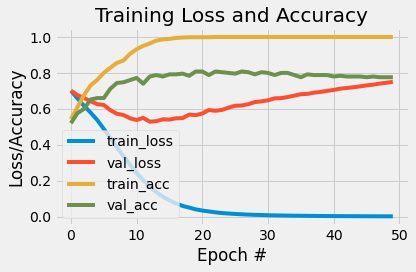

In [86]:
history = model.fit(X_train_pad, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 50)

We can see that by adding the word emebddings as trainable parameters, we get a problem with overfitting. Hence, the more complex the model becomes, the more overfitting we will get. This is a general problem of deep learning networks. When adding deep layers, it is very hard to avoid overfitting. The best solution is to get more data, but this might not be possible. 

## From Pooling to Convolutions

We now add additioanl convolutioanl layers, similar to what we do with image data.

In [87]:
embedding_dim = 100 # bigger network this time

# new model
model = Sequential()

# embedding layer
model.add(Embedding(vocab_size, 
                    embedding_dim, 
                    input_length=maxlen))

# CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Conv1D(128, 5, # convolutional layer with input of 128 and 1D kernel of 5
                activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(10, 
                activation='relu'))
model.add(Dense(1, 
                activation='sigmoid'))

# compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          175700    
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 241,129
Trainable params: 241,129
Non-trainable params: 0
_________________________________________________________________


Now we have 241,000 trainable parameters. The reason that this is so high is because of the embedding layer - the word embeddings are trainable parameters. 

__Train and evaluate__

Training Accuracy: 1.0000
Testing Accuracy:  0.7880


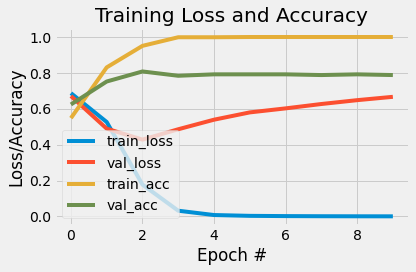

In [88]:
# Train model
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 10)

Again, we have a problem of overfitting the data. The training and validation loss follow each other for a single epoch, and then they diverge. Just after 2 epochs we have 100% accuracy for the training data - hence, the model is overfitting the data. 

## Regularization

Regularization is a way of avoiding overfitting. 

In [89]:
# Defining L2 regularizer - the smaller the value, the more regularization
l2 = L2(0.0001)

Below we have the same model, but the only differnece is that we have the embedding matrix as weights and we are setting the word embeddings as trainable parameters, and we have added the L2 regularization in the convolutional layer and in the dense layer. Hence, we are telling the model to constrain its learning - it is learning more regular parameters, which will perhaps prevent it from overfitting the data. 

In [90]:
embedding_dim = 50 # smaller this time

# New model
model = Sequential()

# Embedding -> CONV+ReLU -> MaxPool -> FC+ReLU -> Out
model.add(Embedding(vocab_size,                  # vocab size from Tokenizer()
                    embedding_dim,               # embedding input layer size
                    weights=[embedding_matrix],  # pretrained embeddings
                    input_length=maxlen,         # maxlen of padded doc
                    trainable=True))             # trainable embeddings
model.add(Conv1D(128, 5, 
                activation='relu',
                kernel_regularizer=l2))          # L2 regularization 
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu', kernel_regularizer=l2))
model.add(Dense(1, activation='sigmoid'))

# compile
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

# print summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 50)           87850     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 10)                1290      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 11        
Total params: 121,279
Trainable params: 121,279
Non-trainable params: 0
_________________________________________________________________


Training Accuracy: 1.0000
Testing Accuracy:  0.8200


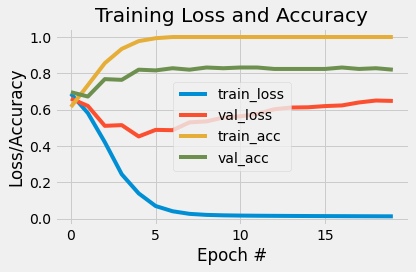

In [91]:
# Train model
history = model.fit(X_train_pad, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test_pad, y_test),
                    batch_size=10)

# evaluate 
loss, accuracy = model.evaluate(X_train_pad, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# plot
plot_history(history, epochs = 20)

We still have a problem of overfitting. Hence, not matter how complex the model gets, we are not going to get above 80% accuracy for the validation data. 

The problem of overfitting is a result of the syntheic nature of the data - it is a toy dataset, which means taht there is not a lot of data and it is not that complex, which means that the model will quickly learn the data, and it will not be able to generalize very well. 

We could try to constrain the model more with a stricter regularization, and see if this affects the testing accuracy, but this might not make that much of a difference. 

__Are there other ways to reduce overfitting?__
1. Get more data 

2. *Data augmentation:* Create more data from existing data which allows us to increase the size of training data. 

2. Regularization

3. *Dropout method:* dropping nodes and layers as the model is learning. In the context of CNNs dropout is not very useful though. 

4. *Early stopping method:* make the model stop learning when either the loss begins to plateau or when it starts to diverge. Hence, we make the model stop after a certain amount of epochs - before it begins to overfit. 

__Is there a way to test how tweaking parameters will influence the results?__
- *Grid search:* running all the different possible combinations of hyperparameters of a model, and see which set of parameters will provide the best result. This takes a very long time because it has to test all the different combinations of parameters. 